In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time

print(tf.__version__)

print('GPU Device: ', tf.test.gpu_device_name())

2.2.0
GPU Device:  /device:GPU:0


In [0]:
def display_image(image):
    fig = plt.figure(figsize=(20,15))
    plt.grid(False)
    plt.imshow(image)
    plt.show()

In [0]:
def download_and_resize(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix='.jpg')
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format='JPEG', quality=90)
    print('Image Downloaded: ', filename)
    if display:
        display_image(pil_image)
    return filename

In [0]:
def bounding_box(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin*im_width, xmax*im_width,
                                  ymin*im_height, ymax*im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

    total_display_str_height = (1 + 2*0.05)*(sum(display_str_heights))

    if top>total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = (0.05 * text_height)
        draw.rectangle([(left, text_bottom-text_height-2*margin), (left+text_width, text_bottom)], fill=color)
        draw.text((left+margin, text_bottom-text_height-margin), display_str, fill='black', font=font)
        text_bottom -= text_height-2*margin

In [0]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print('File Not Found, using default font')
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0] ,max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode('ascii'), int(100*scores[i]))
            color = colors[hash(class_names[i])%len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
            bounding_box(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

Image Downloaded:  /tmp/tmp9n2p_c0o.jpg


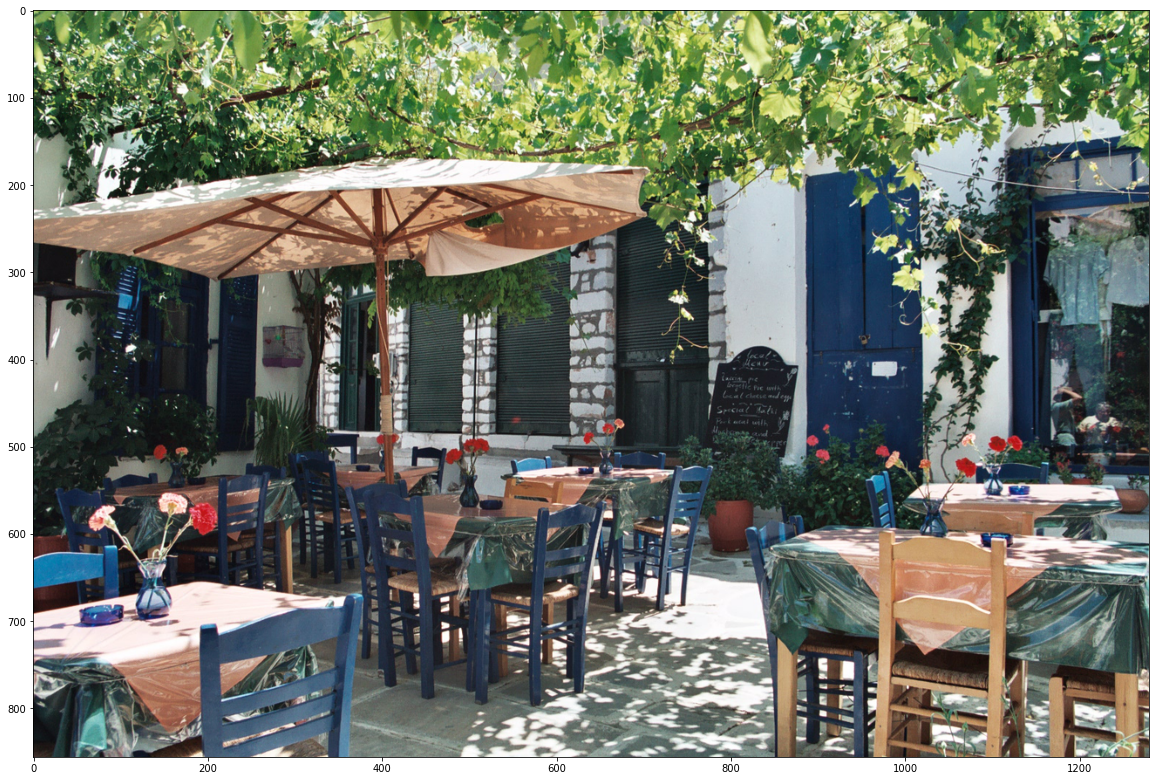

In [6]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
downloaded_image_path = download_and_resize(image_url, 1280, 856, True)

In [7]:
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [0]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key: value.numpy() for key, value in result.items()}

    print('Found %d objects.'%len(result['detection_scores']))
    print('Inference Time: ', end_time-start_time)

    image_with_boxes = draw_boxes(img.numpy(), result['detection_boxes'], result['detection_class_entities'], result['detection_scores'])

    display_image(image_with_boxes)

Found 100 objects.
Inference Time:  8.57507610321045


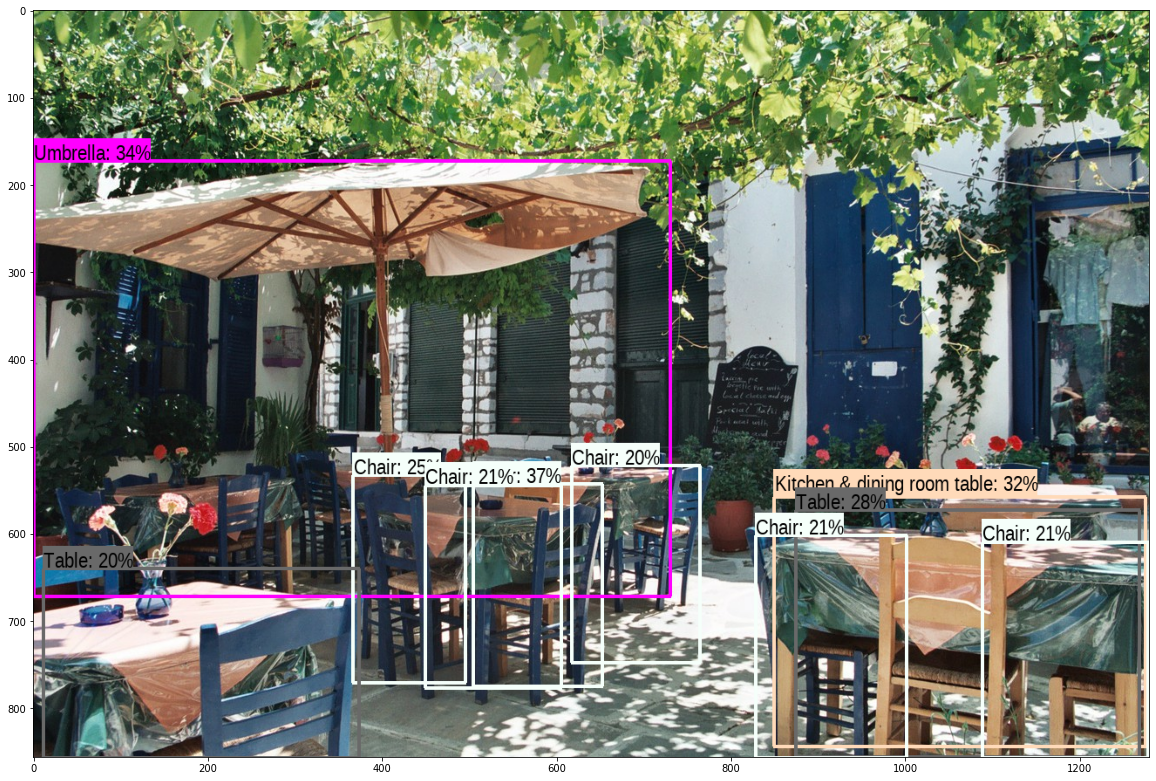

In [10]:
run_detector(detector, downloaded_image_path)

In [0]:
image_urls = ["https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
              "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
              "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg"]

In [0]:
def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize(image_url, 640,480)
    run_detector(detector, image_path)
    end_time = time.time()
    print('Inference Time: ', end_time-start_time)

Image Downloaded:  /tmp/tmpvfhcthjs.jpg
Found 100 objects.
Inference Time:  0.41026926040649414


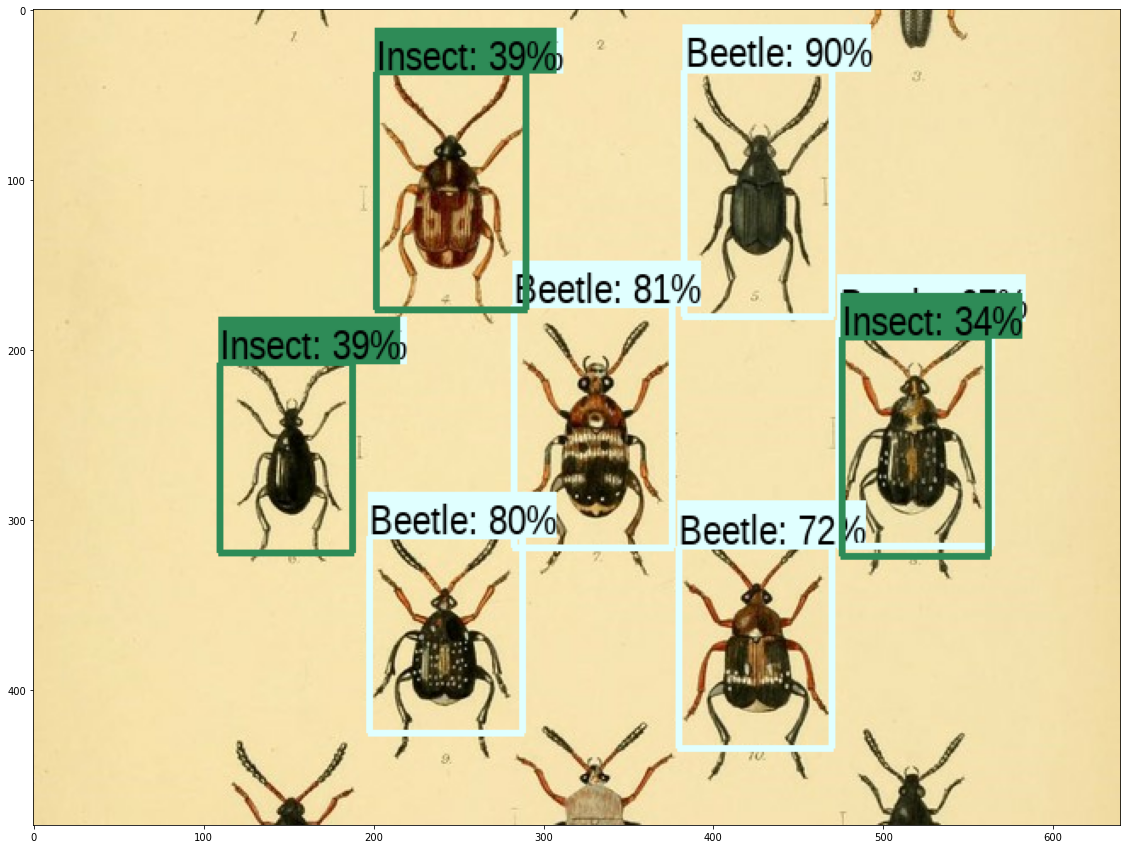

Inference Time:  1.2216708660125732
Image Downloaded:  /tmp/tmpc2fnt27v.jpg
Found 100 objects.
Inference Time:  0.26309919357299805


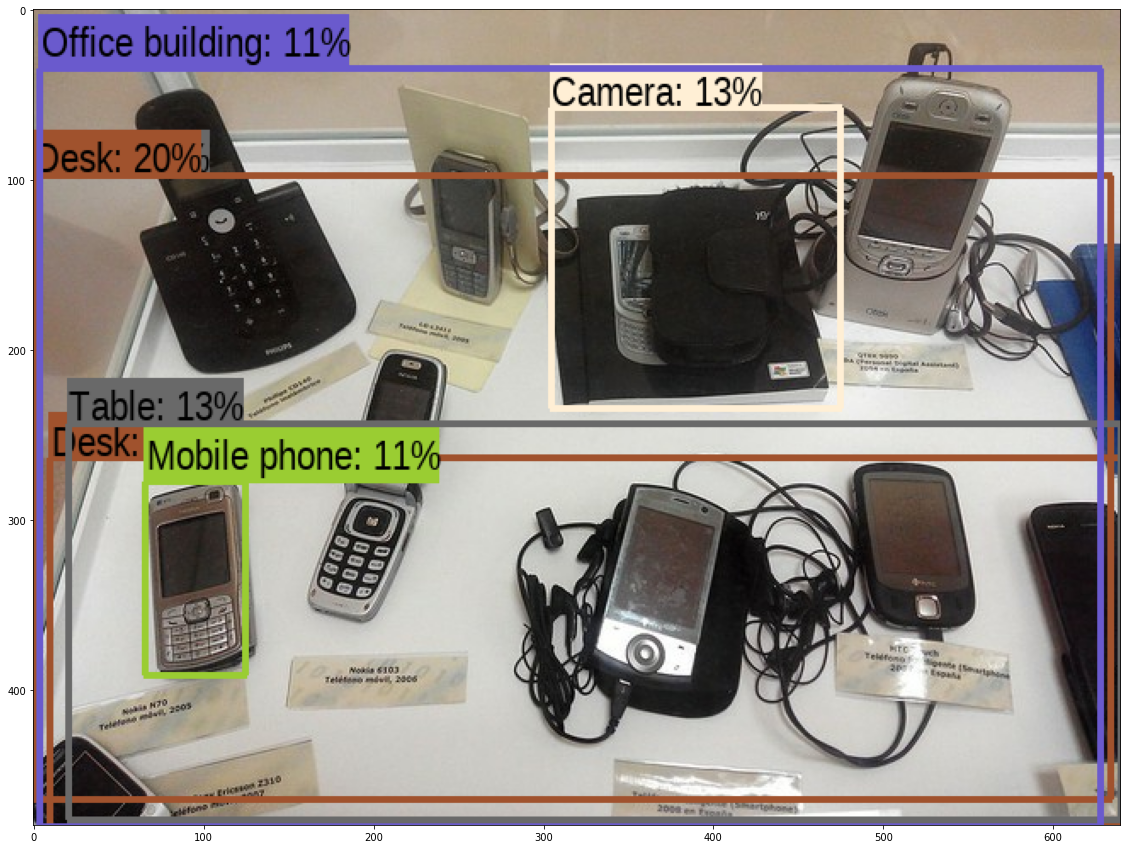

Inference Time:  1.1031525135040283
Image Downloaded:  /tmp/tmpndyovy7c.jpg
Found 100 objects.
Inference Time:  0.22838211059570312


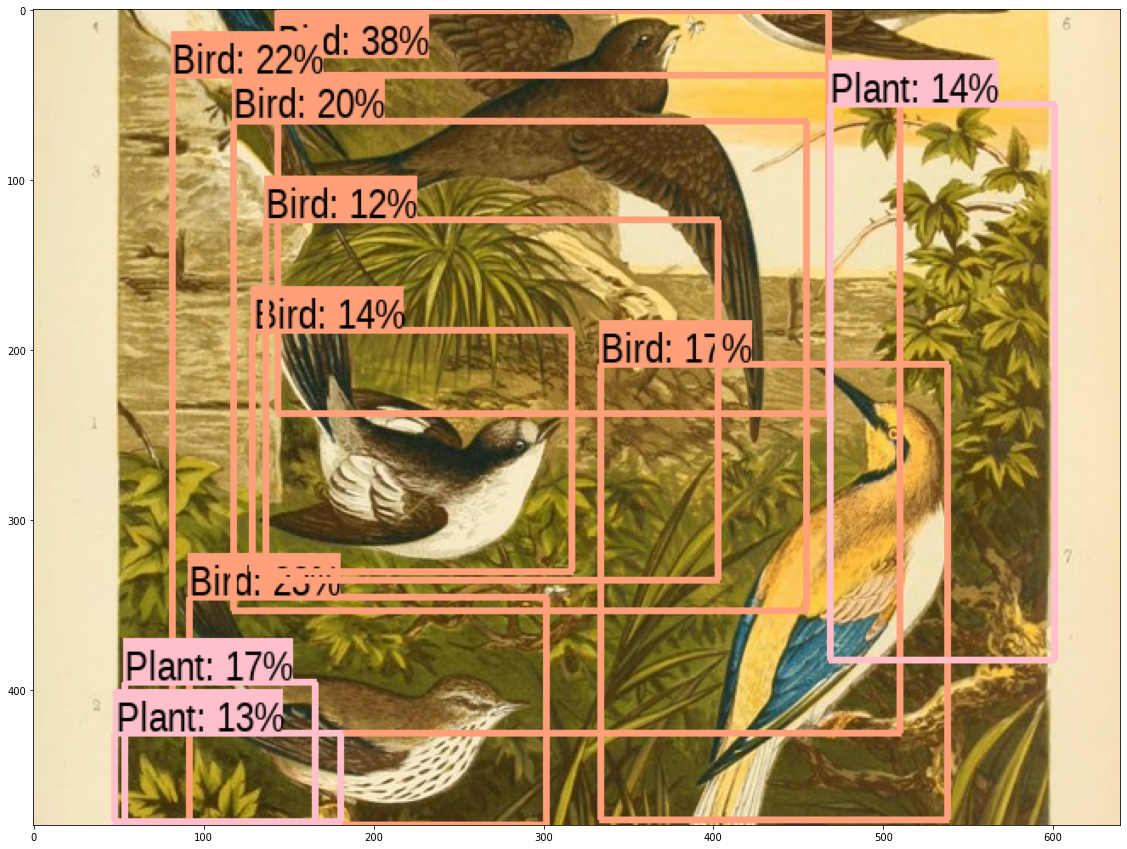

Inference Time:  1.3980882167816162


In [13]:
for i in range(len(image_urls)):
    detect_img(image_urls[i])